# Importing processed data from Google Drive

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
%cd /content/drive/MyDrive/dataset/Pascal_VOC/cache/

/content/drive/MyDrive/dataset/Pascal_VOC/cache


In [63]:
!pip install tensorflow_addons

# Importing required Libraries

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2 # For image resizing.

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.applications import   VGG19, vgg19, VGG16, vgg16, InceptionV3, inception_v3, \
                                            Xception, xception

In [65]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm


#Model Development
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_hub as hub
from tensorflow_addons.metrics import HammingLoss
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import Loss, BinaryCrossentropy
from keras.utils import plot_model
import tensorflow_datasets as tfds
from tensorflow.image import resize, ResizeMethod 
from tensorflow.data import Dataset
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPool2D, \
                                    BatchNormalization, GlobalAveragePooling2D, Lambda, \
                                    Embedding, GlobalAveragePooling1D, Concatenate, LSTM, \
                                    Bidirectional, Input, Reshape
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomTranslation
from tensorflow.keras.applications import   VGG19, vgg19, VGG16, vgg16, InceptionV3, inception_v3, \
                                            Xception, xception
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.models import Model, load_model
from tensorflow.python.keras.utils.layer_utils import count_params
from tensorflow.keras.callbacks import ReduceLROnPlateau

#sklearn
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight

There are 20 labels in this problem

In [66]:
labels = np.array(['person', 'bird', 'cat', 'cow', 'dog', 'horse',
              'sheep', 'aeroplane', 'bicycle', 'boat', 'bus', 'car',
              'motorbike', 'train', 'bottle', 'chair', 'dining table',
              'potted plant', 'sofa', 'tv/monitor'])

Loading the images and targets

In [67]:
get_resized_images = True

In [68]:
if get_resized_images:
    abstract_images = np.load('abstract_images_resized.npy', allow_pickle=True)
else:
    abstract_images = np.load('abstract_images.npy', allow_pickle=True)
abstract_images = abstract_images[:, :, :, :3]

if get_resized_images:
    pascal_images = np.load('pascal_images_resized.npy', allow_pickle=True)
else:
    pascal_images = np.load('pascal_images.npy', allow_pickle=True)

abstract_targets = np.load('abstract_targets.npy', allow_pickle=True)
pascal_targets = np.load('pascal_targets.npy', allow_pickle=True)

abstract_annots = np.load('abstract_annots.npy', allow_pickle=True)
pascal_annots = np.load('pascal_annots.npy', allow_pickle=True)

abstract_annots_concat = np.load('abstract_annots_concat.npy', allow_pickle=True)
pascal_annots_concat = np.load('pascal_annots_concat.npy', allow_pickle=True)

A sample from Abstract50s dataset.

array(['person', 'cat'], dtype='<U12')

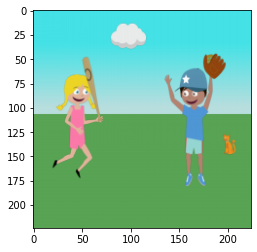

In [69]:
index = 0
if get_resized_images:
  plt.imshow(abstract_images[index]/255)
else:
  plt.imshow(abstract_images[index])
labels[abstract_targets[index] == 1]

A sample from Pascal50s dataset

array(['dog'], dtype='<U12')

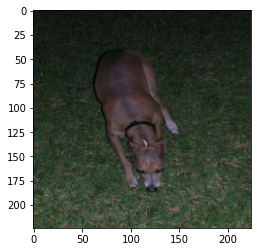

In [70]:
index = 11
if get_resized_images:
  plt.imshow(pascal_images[index]/255)
else:
  plt.imshow(pascal_images[index])
labels[pascal_targets[index] == 1]

Removing alpha channel

In [71]:
abstract_images = abstract_images[:, :, :, :3]

Resizing

In [72]:
def resizing(images):
  temp = []
  for image in images:
    resized = cv2.resize(image, (250, 200), interpolation=cv2.INTER_AREA)
    temp.append(resized)

  images = np.array(temp)
  return images

In [73]:
if not get_resized_images:
  abstract_images = resizing(abstract_images)
  pascal_images = resizing(pascal_images)

Normalization. 

*Note: Abstract50s is normalized by default*

In [74]:
normailize = False

In [75]:
if normailize and np.max(abstract_images) == 255:
  abstract_images = abstract_images / 255

if normailize and np.max(pascal_images) == 255:
  pascal_images = pascal_images / 255

Combining the two datasets

In [76]:
images = np.concatenate((pascal_images, abstract_images), axis=0)

In [77]:
targets = np.concatenate((pascal_targets, abstract_targets), axis=0)

Since our data is extremely imbalanced so we will keep track of the class weights to train the model better.

In [78]:
class_weights = np.sum(targets, axis=0)
class_weights = dict(zip(range(20), class_weights))

We split or dataset into train and test

*Note: the dataset is also shuffled in this process*

In [79]:
X_train, X_test, y_train, y_test = train_test_split(images, targets, test_size=0.2, shuffle=True, random_state=42)

# Model

In [80]:
@tf.function
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1
    macro_cost = tf.reduce_mean(cost)
    return macro_cost

@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [81]:
def get_model():
  model = keras.models.Sequential()
  model.add(layers.Conv2D(input_shape=(images.shape[1],images.shape[2],3),filters=128,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(filters=128, kernel_size=(2,2), padding="same", activation="relu"))
  model.add(layers.BatchNormalization())

  model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))

  model.add(layers.Conv2D(filters=64, kernel_size=(2,2), padding="same", activation="relu"))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(filters=64, kernel_size=(2,2), padding="same", activation="relu"))
  model.add(layers.BatchNormalization())

  model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2), name='MP_2'))

  model.add(layers.Conv2D(filters=32, kernel_size=(2,2), padding="same", activation="relu"))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(filters=32, kernel_size=(2,2), padding="same", activation="relu", name='last_conv'))
  model.add(layers.BatchNormalization())
  headModel = model.output
  headModel = layers.Flatten()(headModel)
  headModel = layers.Dropout(rate=0.1)(headModel)

  headModel = layers.Dense(64, activation='relu')(headModel)
  headModel = layers.Dense(64, activation='relu')(headModel)
  headModel = layers.Dense(len(labels), activation='sigmoid')(headModel)
  model = keras.models.Model(inputs=model.input, outputs=headModel)
  # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  model.compile(optimizer='adam', loss=macro_soft_f1, metrics=[macro_f1])
  return model

In [82]:
def get_cnn_model(pre_trained, input_preprocessor=None, shape=(224, 224, 3), allow_train_from=None):
    inputs = Input(shape=shape)
    if input_preprocessor is not None:
        x = input_preprocessor(inputs)
        x = pre_trained(x)
    else:
        x = pre_trained(inputs)
    if allow_train_from is not None:
        layer_names = [layer.name for layer in pre_trained.layers]
        idx = layer_names.index(allow_train_from)
        for layer in pre_trained.layers[idx:]:
            layer.trainable = True
    return Model(inputs=inputs, outputs=x)

In [83]:
def get_pretrain(name='vgg16', train=False):
  if name == 'inception':
    base_model = InceptionV3(include_top = False, input_shape=(images.shape[1],images.shape[2], 3), weights = 'imagenet', pooling='avg')
    input_preprocessor = inception_v3.preprocess_input
  else:
    base_model = VGG16(input_shape=(images.shape[1],images.shape[2], 3), include_top = False, weights = 'imagenet')
    input_preprocessor = vgg16.preprocess_input
  if not train:
    base_model.trainable = False
  cnn = get_cnn_model(base_model, input_preprocessor)
  x = layers.Flatten()(cnn.output)
  x = layers.Dense(512, activation='relu')(x)
  x = layers.Dense(512, activation='relu')(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(len(labels), activation='sigmoid')(x)

  model = keras.models.Model(cnn.input, x)

  # model.compile(optimizer='adam', loss = 'binary_crossentropy',metrics = ['acc'])
  model.compile(optimizer='adam', loss=macro_soft_f1, metrics=[macro_f1])
  return model


In [84]:
# model = get_model()
model = get_pretrain('inception')

In [85]:
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_10 (Dense)             (None, 512)               2626

We will use the follow two callbacks
- Early Stopping - To prevent overfitting
- Model Checkpoint - To save our model's training progress.

In [86]:
es = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
cp = keras.callbacks.ModelCheckpoint('model1.h5', save_best_only=True)
tb = keras.callbacks.TensorBoard(log_dir='logs', histogram_freq=1, write_graph=True, update_freq='epoch', 
                                 profile_batch=2, embeddings_freq=1)

### The training begins !

Note: the class_weights arugment is passed to acknowlegde the imbalanced dataset

In [87]:
model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32, callbacks=[es, cp, tb])

Epoch 1/50
38/38 [==============================] - 15s 276ms/step - loss: 0.7840 - macro_f1: 0.2249 - val_loss: 0.6504 - val_macro_f1: 0.3522
Epoch 2/50
38/38 [==============================] - 8s 201ms/step - loss: 0.6098 - macro_f1: 0.4025 - val_loss: 0.6004 - val_macro_f1: 0.3884
Epoch 3/50
38/38 [==============================] - 7s 198ms/step - loss: 0.5279 - macro_f1: 0.4841 - val_loss: 0.5820 - val_macro_f1: 0.4041
Epoch 4/50
38/38 [==============================] - 7s 199ms/step - loss: 0.4995 - macro_f1: 0.5060 - val_loss: 0.5902 - val_macro_f1: 0.4010
Epoch 5/50
38/38 [==============================] - 7s 197ms/step - loss: 0.4973 - macro_f1: 0.5038 - val_loss: 0.5838 - val_macro_f1: 0.4027
Epoch 6/50
38/38 [==============================] - 8s 199ms/step - loss: 0.4532 - macro_f1: 0.5526 - val_loss: 0.5512 - val_macro_f1: 0.4373
Epoch 7/50
38/38 [==============================] - 8s 201ms/step - loss: 0.4306 - macro_f1: 0.5735 - val_loss: 0.5617 - val_macro_f1: 0.4266
Epoch

# Evaluation

In [88]:
model.evaluate(X_test, y_test)

10/10 [==============================] - 2s 158ms/step - loss: 0.5425 - macro_f1: 0.4503


[0.5425300598144531, 0.45029115676879883]

In [89]:
preds = (model.predict(images) > 0.5) * 1

## F1 score

This is a better metrics of measurement as the dataset is imbalanced

In [90]:
print(classification_report(preds, targets))

              precision    recall  f1-score   support

           0       1.00      0.73      0.84      1500
           1       0.48      0.91      0.63        56
           2       0.37      0.98      0.54        49
           3       0.83      0.86      0.84        57
           4       0.70      0.35      0.47       410
           5       0.80      0.96      0.87        50
           6       0.72      0.93      0.81        44
           7       0.70      0.91      0.79        86
           8       0.92      0.71      0.80        80
           9       0.91      0.98      0.95        54
          10       0.90      0.81      0.86        70
          11       0.53      0.76      0.62        93
          12       0.92      0.93      0.93       106
          13       0.85      0.85      0.85        65
          14       0.51      0.50      0.51        70
          15       0.63      0.75      0.68       106
          16       0.65      0.51      0.57       307
          17       0.84    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [91]:
np.sum(preds, axis=0)

array([1500,   56,   49,   57,  410,   50,   44,   86,   80,   54,   70,
         93,  106,   65,   70,  106,  307,  277,  102,  113])

In [92]:
%load_ext tensorboard

In [96]:
!tensorboard — logdir /content/drive/MyDrive/dataset/Pascal_VOC/cache/logs

2021-05-11 13:00:48.857560: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
usage: tensorboard [-h] [--helpfull] {serve,dev} ...
tensorboard: error: invalid choice: '—' (choose from 'serve', 'dev')
